In [1]:
# Analysis
import numpy as np
import networkx as nx
import rigidpy as rp
import os
from scipy.optimize import minimize, curve_fit
from scipy.linalg import eigh

# Visualization
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

### Generating Networks:

#### Accounting for aspect ratio of hexagons to get a system that is close to square
Networks are created using the hexagonal_lattice_graph function in the networkx package to create a periodic hexagonal lattice of $N_{rows}$ hexagons by $N_{cols}$ hexagons. $N_{rows}$ is an input parameter and $N_{cols}$ is calculated to make the lattice as close to a square as possible due to the $2:\sqrt{3}$ aspect ratio of hexagons. $N_{cols}$ is calculated from $N_{rows}$ by rounding $\frac{2}{\sqrt{3}}N_{rows}$ to the nearest integer value. But since networkx does not allow for an odd number of columns with periodic boundary conditions, when $N_{cols}$ as calculated above is odd, 1 is added to $N_{cols}$ if in the last step it was rounded down and 1 is subtracted if it was rounded up.

#### Drift y-values from networkx implementation
Lastly, networkx adds a drift value to the y-coordinates of points in the hexagonal lattice when there are periodic boundaries, so this is corrected for by resetting the y-coordinates for all points to be consistent with the first column which does not have a drift.

#### Applying disorder to the network
disorder is added to the network by adding a randomly oriented vector of size d to each node. The resulting network will serve as the starting network where all bond-lengths are equivalent to the rest-lengths so that it starts with no energy in the system. Rest-lengths are then altered to add prestress in the system as detailed below. We tried networks with disorder values Wildtype: d=0.0875, E-cad RNAi: d=0.158


### Prestressing Networks:

#### Applying prestrain
To conduct the prestressing in only one portion of the network, I identify bonds with a location (defined by the center-point of the bond) in the relevant area of interest from the version of the network with no disorder. We make sure to include periodic bonds which may have a position that is negative due to wrap-around. Note that depending on the initial network construction from the sizing and aspect ratio considerations mentioned above, the area percentage may not be exact, but network sizes run here were chosen here such that area percentages of 50% are exact. These bonds are contracted by a target prestrain value $\epsilon_p = \frac{\ell}{\ell_0} - 1$ by resetting their rest-lengths to $\ell_0 = \frac{\ell}{1 + \epsilon_p}$.

#### Energy minimization
After the application of prestress, the network has to be equillibrated to see the propogation of stress through the network. This is done using the rigidpy package configuration class and the scipy.optimize.minimize function with a tolerance of 1e-20.

#### Evaluation of rigidity
Rigidity of the network can be determined by finding the lowest non-trivial eigenvalue of the system. This is done using the rigidpy package which finds calculates the hessian matrix of the system and finds the corresponding eigenvalues.

In [2]:
# save a network
def save(F, folder_name):
    os.mkdir(folder_name)
    np.save(folder_name + '/nodes.npy', F.coordinates)
    np.save(folder_name + '/bonds.npy', F.bonds)
    np.save(folder_name + '/basis.npy', F.basis)
    np.save(folder_name + '/ks.npy', np.diag(F.K))
    np.save(folder_name + '/l0s.npy', F.L0)

# load a network thats been saved
def load(folder_name):
    nodes = np.load(folder_name + '/nodes.npy')
    bonds = np.load(folder_name + '/bonds.npy')
    basis = np.load(folder_name + '/basis.npy')
    ks = np.load(folder_name + '/ks.npy')
    l0s = np.load(folder_name + '/l0s.npy')
    F = rp.framework(nodes, bonds, basis, k=ks, restLengths = l0s)
    return F

In [3]:
# corrects y drift in networkx node position calculation and returns corrected positions
def correct_drift(nodes, N):
    nodes_copy = np.copy(nodes)    # secure copy of nodes
    ys = nodes[0:2*N].T[1]         # first column y positions
    
    # set y positions as the first column y positions in secure copy of nodes
    nodes_copy[:, 1] = np.tile(ys, int(len(nodes_copy)/len(ys)))
    return nodes_copy

In [4]:
# creates a hexagonal network
def create_network(Nrows):
    
    # set Ncols so that it closes to a square using aspect ratio of a hexagon 2:sqrt(3)
    Ncols = int(np.round(Nrows * 2 / np.sqrt(3)))
    
    # check if Ny is odd (networkx doesn't allow Ny to be odd). Add 1 if Ny is larger and subtract 1 if smaller
    if Ncols%2 == 1:
        if Ncols > Nrows * 2 / np.sqrt(3):
            Ncols = Ncols - 1
        else:
            Ncols = Ncols + 1
            
    G = nx.hexagonal_lattice_graph(Nrows, Ncols, periodic = True) # generate periodic hexagonal lattice
    pos = nx.get_node_attributes(G, 'pos')                        # get lattice positions
    nodes = np.array(list(pos.values()))                          # convert dictionary positions to numpy array
    nodes_corrected = correct_drift(nodes, Nrows)                 # correct node drift
    A = np.array(nx.adjacency_matrix(G).todense(), dtype = bool)  # find adjacency matrix
    
    # find unique bonds from adjacency matrix
    node_inds = np.arange(len(nodes_corrected), dtype = int)                   
    b1 = np.repeat(node_inds, 3)
    b2 = (node_inds * np.ones((len(node_inds), len(node_inds)), dtype = int))[A] 
    bonds = np.unique(np.sort(np.vstack((b1, b2)).T, axis = 1), axis = 0)
    
    # find basis
    Lx = np.max(nodes_corrected[:, 0]) + 1.0
    Ly = np.max(nodes_corrected[:, 1]) + np.sqrt(3) / 2
    basis = np.array([[Lx, 0], [0, Ly]])
    
    # return rigidpy framework
    F = rp.framework(nodes_corrected, bonds, basis) 
    return F

In [5]:
def add_disorder(F, d):
    nodes = np.copy(F.coordinates)
    random_angles = np.random.uniform(-np.pi, np.pi, len(nodes))
    dx = np.cos(random_angles)
    dy = np.sin(random_angles)
    offsets = d * np.vstack((dx, dy)).T
    nodes = nodes + offsets
    F_dis = rp.framework(nodes, F.bonds, F.basis, k=np.diag(F.K))
    return F_dis

In [6]:
# plot network with bond forces corresponding to the bond color (red=tension, blue=compression) and bond width
# corresponding to its spring constant k
def plot(F):
    ks = np.diag(F.K)
    stresses = ks * (F.edgeLengths() - F.L0)
    color_norm  = colors.Normalize(vmin=-np.max(np.abs(stresses)), vmax=np.max(np.abs(stresses)))
    #color_norm  = colors.Normalize(vmin=-5e-5, vmax=5e-5)
    scalar_color_map = cmx.ScalarMappable(norm=color_norm, cmap="coolwarm")
    
    for i in range(len(F.bonds)):
        [n1_ind, n2_ind] = F.bonds[i]
        [n1x, n1y] = F.coordinates[n1_ind]
        [n2x, n2y] = F.coordinates[n2_ind]
        bond_length = np.sqrt((n1x - n2x)**2 + (n1y - n2y)**2)
        if np.all(stresses == 0):
            color = 'lightgray'
        else:
            color = scalar_color_map.to_rgba(stresses[i])
        if bond_length < 0.5 * np.max([F.basis[0][0], F.basis[1][1]]):
            #plt.plot([n1x, n2x], [n1y, n2y], color = color, linewidth = 2 * ks[i])
            plt.plot([n1x, n2x], [n1y, n2y], color = color, linewidth = 2)

    plt.axis('equal')
    plt.axis('off')

In [7]:
# energy minimize network
def energy_minimize(F):
    
    # create a configuration for energy minimization functions
    config = rp.configuration(F.coordinates, F.bonds, F.basis, np.diag(F.K))
    
    # minimize using config forces and hessian function with framework rest lengths
    # and chosen tolerance
    result = minimize(fun=config.energy, 
                      x0=config.x0, 
                      args=(F.L0, F.L0),
                      method="Newton-CG",
                      jac=config.forces,
                      hess=config.hessian,
                      tol = 1e-20)

    relaxed_coordinates = result.x.reshape(F.coordinates.shape)
    F_relaxed = rp.framework(relaxed_coordinates, F.bonds, F.basis, k=np.diag(F.K), restLengths=F.L0)
    return F_relaxed

In [8]:
# find center point of each bond
def bond_locations(F):
    nis = F.bonds.T[0]
    nis_pos = F.coordinates[nis]
    njs_pos = nis_pos - F.dr
    return (nis_pos + njs_pos) / 2

In [9]:
# prestresses the top area_percentage of bonds at a strain of eps_p and the non prestrained bonds are given 
# spring constant k_weak while prestrained bonds are kept at a spring constant of 1
def partial_prestress(Fd0, F, area_percentage, eps_p, k_weak = 1):
    
    # mask of bonds that will be prestrained
    bond_locs = bond_locations(Fd0)
    prestrain_bond_mask = np.logical_or(bond_locs[:, 1] >= area_percentage * Fd0.basis[1][1], bond_locs[:, 1] < 0)
    
    # weaken bonds that are not being prestrained
    ks = np.ones(len(F.bonds))
    ks[np.logical_not(prestrain_bond_mask)] = k_weak
    
    # prestrain bonds in the prestrain bond_mask
    prestrains = np.zeros(len(F.bonds))
    prestrains[prestrain_bond_mask] = eps_p
    prestrained_L0s = F.edgeLengths() / (1 + prestrains)
    
    # create prestrained network and energy minimize
    F_prestrained = rp.framework(F.coordinates, F.bonds, F.basis, k=ks, restLengths = prestrained_L0s)
    F_prestrained_minimized = energy_minimize(F_prestrained)
    
    return F_prestrained_minimized

In [10]:
def lowest_eig(F):
    return F.eigenSpace()[0][2]

In [11]:
# create networks
'''
#Nxs = [22, 25, 28]
WT_d = 0.0875
d_intermediate = 0.123
Ecad_d = 0.158
d_large = 0.316

F25 = create_network(25)

sample_num = 10

for i in range(sample_num):
    F25_WT = add_disorder(F25, WT_d)
    F25_intermediate = add_disorder(F25, d_intermediate)
    F25_Ecad = add_disorder(F25, Ecad_d)
    F25_large = add_disorder(F25, d_large)

    save(F25_WT, 'networks_no_prestress/N28_WT_ind' + str(i))
    save(F25_intermediate, 'networks_no_prestress/N28_int_ind' + str(i))
    save(F25_Ecad, 'networks_no_prestress/N28_Ecad_ind' + str(i))
    save(F25_large, 'networks_no_prestress/N28_large_ind' + str(i))
#'''

"\n#Nxs = [22, 25, 28]\nWT_d = 0.0875\nd_intermediate = 0.123\nEcad_d = 0.158\nd_large = 0.316\n\nF25 = create_network(25)\n\nsample_num = 10\n\nfor i in range(sample_num):\n    F25_WT = add_disorder(F25, WT_d)\n    F25_intermediate = add_disorder(F25, d_intermediate)\n    F25_Ecad = add_disorder(F25, Ecad_d)\n    F25_large = add_disorder(F25, d_large)\n\n    save(F25_WT, 'networks_no_prestress/N28_WT_ind' + str(i))\n    save(F25_intermediate, 'networks_no_prestress/N28_int_ind' + str(i))\n    save(F25_Ecad, 'networks_no_prestress/N28_Ecad_ind' + str(i))\n    save(F25_large, 'networks_no_prestress/N28_large_ind' + str(i))\n#"

In [12]:
'''
eps_ps_test = np.geomspace(1e-3, 3e-1)

Nx = 22
F0 = create_network(Nx)

for i in range(10):
    lowest_eigs_WT = []
    lowest_eigs_int = []
    lowest_eigs_Ecad = []
    lowest_eigs_large = []
    for j in range(len(eps_ps_test)):
        F_WT = load('networks_no_prestress/N' + str(Nx) + '_WT_ind' + str(i))
        F_int = load('networks_no_prestress/N' + str(Nx) + '_int_ind' + str(i))
        F_Ecad = load('networks_no_prestress/N' + str(Nx) + '_Ecad_ind' + str(i))
        F_large = load('networks_no_prestress/N' + str(Nx) + '_large_ind' + str(i))
        
        F_WT_p = partial_prestress(F0, F_WT, 0.5, eps_ps_test[j])
        F_int_p = partial_prestress(F0, F_int, 0.5, eps_ps_test[j])
        F_Ecad_p = partial_prestress(F0, F_Ecad, 0.5, eps_ps_test[j])
        F_large_p = partial_prestress(F0, F_large, 0.5, eps_ps_test[j])
        
        save(F_WT_p, 'networks/N' + str(Nx) + '_WT_ind' + str(i) + '_pind' + str(j))
        save(F_int_p, 'networks/N' + str(Nx) + '_int_ind' + str(i) + '_pind' + str(j))
        save(F_Ecad_p, 'networks/N' + str(Nx) + '_Ecad_ind' + str(i) + '_pind' + str(j))
        save(F_large_p, 'networks/N' + str(Nx) + '_large_ind' + str(i) + '_pind' + str(j))
        
        lowest_eigs_WT.append(lowest_eig(F_WT_p))
        lowest_eigs_int.append(lowest_eig(F_int_p))
        lowest_eigs_Ecad.append(lowest_eig(F_Ecad_p))
        lowest_eigs_large.append(lowest_eig(F_large_p))
        
    np.save('network_data/lowest_eigs_N' + str(Nx) + '_WT_ind' + str(i) + '.npy', lowest_eigs_WT)
    np.save('network_data/lowest_eigs_N' + str(Nx) + '_int_ind' + str(i) + '.npy', lowest_eigs_int)
    np.save('network_data/lowest_eigs_N' + str(Nx) + '_Ecad_ind' + str(i) + '.npy', lowest_eigs_Ecad)
    np.save('network_data/lowest_eigs_N' + str(Nx) + '_large_ind' + str(i) + '.npy', lowest_eigs_large)
'''

"\neps_ps_test = np.geomspace(1e-3, 3e-1)\n\nNx = 22\nF0 = create_network(Nx)\n\nfor i in range(10):\n    lowest_eigs_WT = []\n    lowest_eigs_int = []\n    lowest_eigs_Ecad = []\n    lowest_eigs_large = []\n    for j in range(len(eps_ps_test)):\n        F_WT = load('networks_no_prestress/N' + str(Nx) + '_WT_ind' + str(i))\n        F_int = load('networks_no_prestress/N' + str(Nx) + '_int_ind' + str(i))\n        F_Ecad = load('networks_no_prestress/N' + str(Nx) + '_Ecad_ind' + str(i))\n        F_large = load('networks_no_prestress/N' + str(Nx) + '_large_ind' + str(i))\n        \n        F_WT_p = partial_prestress(F0, F_WT, 0.5, eps_ps_test[j])\n        F_int_p = partial_prestress(F0, F_int, 0.5, eps_ps_test[j])\n        F_Ecad_p = partial_prestress(F0, F_Ecad, 0.5, eps_ps_test[j])\n        F_large_p = partial_prestress(F0, F_large, 0.5, eps_ps_test[j])\n        \n        save(F_WT_p, 'networks/N' + str(Nx) + '_WT_ind' + str(i) + '_pind' + str(j))\n        save(F_int_p, 'networks/N' + st

### k0 test

In [13]:
'''
Nx = 25
net_ind = 0
F_WT = load('networks_no_prestress/N' + str(Nx) + '_WT_ind' + str(net_ind))
F_copy_Klarge = rp.framework(F_WT.coordinates, F_WT.bonds, F_WT.basis, k = 100 * np.ones(len(F_WT.bonds)))
F0 = create_network(Nx)

eps_ps_test = np.geomspace(1e-3, 3e-1)
lowest_eigs = []
for i in range(len(eps_ps_test)):
    F_WT_p = partial_prestress(F0, F_copy_Klarge, 0.5, eps_ps_test[i])
    save(F_WT_p, 'K0_test_networks/N' + str(Nx) + '_WT_ind' + str(net_ind) + '_pind' + str(i))
    lowest_eigs.append(lowest_eig(F_WT_p))
np.save('K0_test_data/lowest_eigs_N' + str(Nx) + '_WT_ind' + str(net_ind) + '.npy', lowest_eigs)
#'''

"\nNx = 25\nnet_ind = 0\nF_WT = load('networks_no_prestress/N' + str(Nx) + '_WT_ind' + str(net_ind))\nF_copy_Klarge = rp.framework(F_WT.coordinates, F_WT.bonds, F_WT.basis, k = 100 * np.ones(len(F_WT.bonds)))\nF0 = create_network(Nx)\n\neps_ps_test = np.geomspace(1e-3, 3e-1)\nlowest_eigs = []\nfor i in range(len(eps_ps_test)):\n    F_WT_p = partial_prestress(F0, F_copy_Klarge, 0.5, eps_ps_test[i])\n    save(F_WT_p, 'K0_test_networks/N' + str(Nx) + '_WT_ind' + str(net_ind) + '_pind' + str(i))\n    lowest_eigs.append(lowest_eig(F_WT_p))\nnp.save('K0_test_data/lowest_eigs_N' + str(Nx) + '_WT_ind' + str(net_ind) + '.npy', lowest_eigs)\n#"

### k test

In [14]:
'''
Nx = 25
net_ind = 0
F_WT = load('networks_no_prestress/N' + str(Nx) + '_WT_ind' + str(net_ind))
F0 = create_network(Nx)

ks = np.array([1e-1, 1e-2, 1e-3])
eps_ps_test = np.geomspace(1e-3, 3e-1)

for i in range(len(ks)):
    lowest_eigs = []
    for j in range(len(eps_ps_test)):
        F_WT_p = partial_prestress(F0, F_WT, 0.5, eps_ps_test[j], k_weak = ks[i])
        save(F_WT_p, 'K_test_networks/N' + str(Nx) + '_WT_ind' + str(net_ind) + '_kind' + str(i) + '_pind' + str(j))
        lowest_eigs.append(lowest_eig(F_WT_p))
    np.save('K_test_data/lowest_eigs_N' + str(Nx) + '_WT_ind' + str(net_ind) + '_kind' + str(i) + '.npy', lowest_eigs)
#'''

"\nNx = 25\nnet_ind = 0\nF_WT = load('networks_no_prestress/N' + str(Nx) + '_WT_ind' + str(net_ind))\nF0 = create_network(Nx)\n\nks = np.array([1e-1, 1e-2, 1e-3])\neps_ps_test = np.geomspace(1e-3, 3e-1)\n\nfor i in range(len(ks)):\n    lowest_eigs = []\n    for j in range(len(eps_ps_test)):\n        F_WT_p = partial_prestress(F0, F_WT, 0.5, eps_ps_test[j], k_weak = ks[i])\n        save(F_WT_p, 'K_test_networks/N' + str(Nx) + '_WT_ind' + str(net_ind) + '_kind' + str(i) + '_pind' + str(j))\n        lowest_eigs.append(lowest_eig(F_WT_p))\n    np.save('K_test_data/lowest_eigs_N' + str(Nx) + '_WT_ind' + str(net_ind) + '_kind' + str(i) + '.npy', lowest_eigs)\n#"

In [202]:
def linear_fit(x, m, y0):
    return (m * x) + y0

def fit(x, alpha, A):
    return A*(x**alpha)

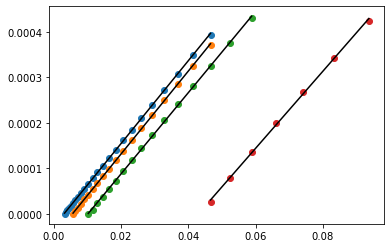

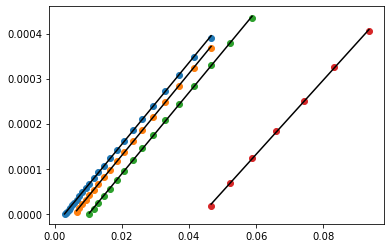

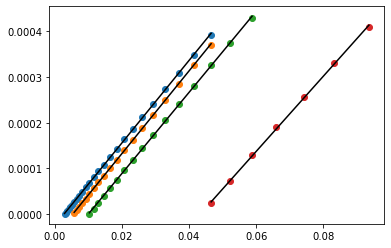

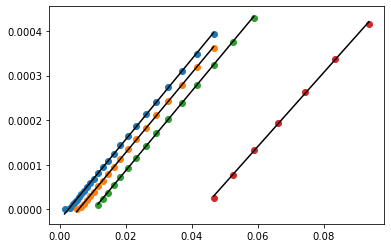

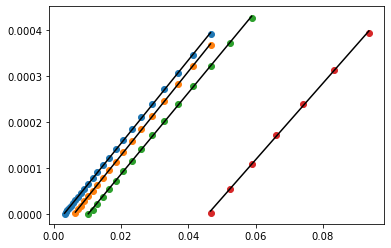

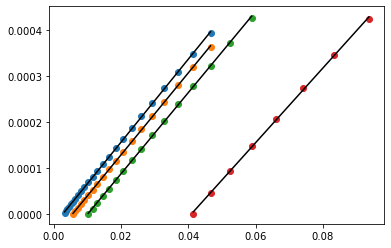

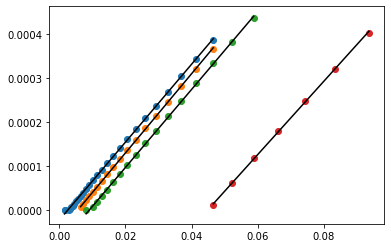

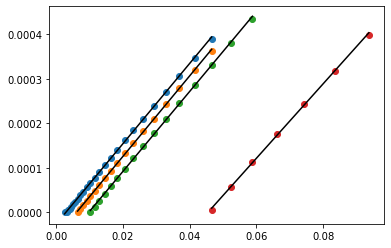

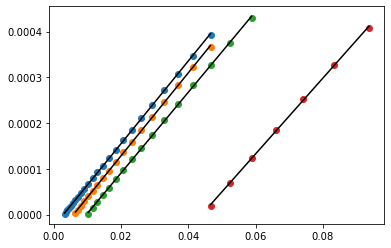

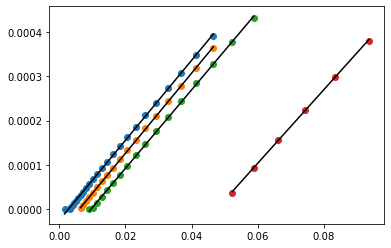

In [220]:
eps_ps_test = np.geomspace(1e-3, 3e-1)
ds = ['WT', 'int', 'Ecad', 'large']

ms = np.zeros((10, 4))
y0s = np.zeros((10, 4))


cut_offs = [0.05, 0.05, 0.06, 0.1]

for i in range(10):
    for j in range(4):

        data = np.load('network_data/lowest_eigs_N' + str(28) + '_' + ds[j] + '_ind' + str(i) + '.npy')
        fit_inds = np.arange(len(data))[np.logical_and(data > 0, eps_ps_test < cut_offs[j])]
        data_to_fit = data[fit_inds]
        eps_ps_test_to_fit = eps_ps_test[fit_inds]

        popt, pcov = curve_fit(linear_fit, eps_ps_test_to_fit, data_to_fit)

        plt.scatter(eps_ps_test_to_fit, data_to_fit)
        plt.plot(eps_ps_test_to_fit, linear_fit(eps_ps_test_to_fit, popt[0], popt[1]), color = 'black')
        #plt.xscale('log')
        #plt.yscale('log')

    plt.show()

0.8364626327710963
0.9967397752064933


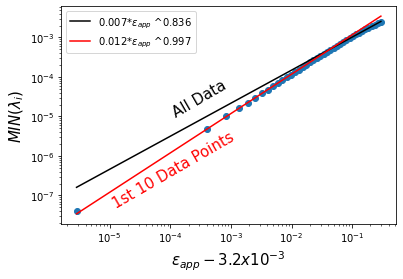

In [233]:
eps_ps_test = np.geomspace(1e-3, 3e-1)
ds = ['WT', 'int', 'Ecad', 'large']

ms = np.zeros((10, 4))
y0s = np.zeros((10, 4))


for i in range(1):
    for j in range(1):

        data = np.load('network_data/lowest_eigs_N' + str(25) + '_' + ds[j] + '_ind' + str(i) + '.npy')
        fit_inds = np.arange(len(data))[data > 0]#[np.logical_and(data > 0, eps_ps_test < 0.06)]
        data_to_fit = data[fit_inds]
        eps_ps_test_to_fit = eps_ps_test[fit_inds]

        popt, pcov = curve_fit(fit, eps_ps_test_to_fit - 3.2e-3, data_to_fit)
        
        popt2, pcov2 = curve_fit(fit, (eps_ps_test_to_fit - 3.2e-3)[0:10], data_to_fit[0:10])

        print(popt[0])
        print(popt2[0])

        plt.scatter(eps_ps_test_to_fit - 3.2e-3, data_to_fit)
        plt.plot(eps_ps_test_to_fit- 3.2e-3, fit(eps_ps_test_to_fit - 3.2e-3, popt[0], popt[1]), color = 'black'\
                 , label = str(round(popt[1], 3)) + '$*\epsilon_{app}$ ^' +str(round(popt[0], 3)))
        plt.plot(eps_ps_test_to_fit- 3.2e-3, fit(eps_ps_test_to_fit - 3.2e-3, popt2[0], popt2[1]), color = 'red'\
                 , label = str(round(popt2[1], 3)) + '$*\epsilon_{app}$ ^' + str(round(popt2[0], 3)))
        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
        plt.text(1e-4, 1e-5, 'All Data', rotation = 30, fontsize = 15)
        plt.text(1e-5, 5e-8, '1st 10 Data Points', rotation = 30, fontsize = 15, color = 'red')
        
        plt.xlabel('$\epsilon_{app} - 3.2x10^{-3}$', fontsize = 15)
        plt.ylabel('$MIN(\lambda_i)$', fontsize = 15)
        
    plt.show()
    

In [120]:
-y0s / ms

array([[0.00241925, 0.00517144, 0.01008975, 0.04179487],
       [0.00220705, 0.00526211, 0.0091171 , 0.04599051],
       [0.00249856, 0.00514346, 0.00869916, 0.04471677],
       [0.00222388, 0.00557054, 0.00927144, 0.04188368],
       [0.00209799, 0.00546188, 0.00895454, 0.04361161],
       [0.00215445, 0.00508257, 0.00948565, 0.04633267],
       [0.00242452, 0.00527346, 0.00878041, 0.04806367],
       [0.00223026, 0.00506906, 0.0086693 , 0.04323036],
       [0.00209229, 0.00564497, 0.00875202, 0.04558569],
       [0.00246329, 0.00509808, 0.00915934, 0.04544446]])

In [11]:
def calculate_eps_p_star(eps_ps_test, data, cut_off_prestrain):
    fit_inds = np.arange(len(data))[np.logical_and(data > 0, eps_ps_test < cut_off_prestrain)]
    data_to_fit = data[fit_inds]
    eps_ps_test_to_fit = eps_ps_test[fit_inds]

    popt, pcov = curve_fit(linear_fit, eps_ps_test_to_fit, data_to_fit)
    m = popt[0]
    y0 = popt[1]
    return -y0 / m

<ipython-input-242-a97d5d97b3ff>:21: RuntimeWarning: invalid value encountered in sqrt
  WT_means = np.mean(np.sqrt(WT_all), axis = 1)
<ipython-input-242-a97d5d97b3ff>:22: RuntimeWarning: invalid value encountered in sqrt
  int_means = np.mean(np.sqrt(int_all), axis = 1)
<ipython-input-242-a97d5d97b3ff>:23: RuntimeWarning: invalid value encountered in sqrt
  Ecad_means = np.mean(np.sqrt(Ecad_all), axis = 1)
<ipython-input-242-a97d5d97b3ff>:24: RuntimeWarning: invalid value encountered in sqrt
  large_means = np.mean(np.sqrt(large_all), axis = 1)
<ipython-input-242-a97d5d97b3ff>:26: RuntimeWarning: invalid value encountered in sqrt
  WT_stds = np.std(np.sqrt(WT_all), axis = 1)
<ipython-input-242-a97d5d97b3ff>:27: RuntimeWarning: invalid value encountered in sqrt
  int_stds = np.std(np.sqrt(int_all), axis = 1)
<ipython-input-242-a97d5d97b3ff>:28: RuntimeWarning: invalid value encountered in sqrt
  Ecad_stds = np.std(np.sqrt(Ecad_all), axis = 1)
<ipython-input-242-a97d5d97b3ff>:29: Runtim

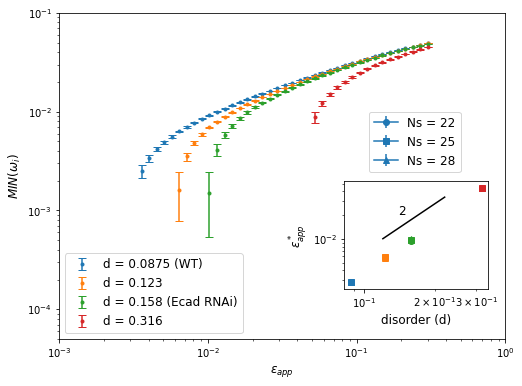

In [242]:
WT_d = 0.0875
d_intermediate = 0.123
Ecad_d = 0.158
d_large = 0.316

fig, ax = plt.subplots(figsize = (8, 6))

Nxs = [22, 25, 28]
WT_all = np.zeros((len(Nxs), 10, len(eps_ps_test)))
int_all = np.zeros((len(Nxs), 10, len(eps_ps_test)))
Ecad_all = np.zeros((len(Nxs), 10, len(eps_ps_test)))
large_all = np.zeros((len(Nxs), 10, len(eps_ps_test)))

for i in range(len(Nxs)):
    for j in range(10):
        WT_all[i][j] = np.load('network_data/lowest_eigs_N' + str(Nxs[i]) + '_WT_ind' + str(j) + '.npy')
        int_all[i][j] = np.load('network_data/lowest_eigs_N' + str(Nxs[i]) + '_int_ind' + str(j) + '.npy')
        Ecad_all[i][j] = np.load('network_data/lowest_eigs_N' + str(Nxs[i]) + '_Ecad_ind' + str(j) + '.npy')
        large_all[i][j] = np.load('network_data/lowest_eigs_N' + str(Nxs[i]) + '_large_ind' + str(j) + '.npy')
    
WT_means = np.mean(np.sqrt(WT_all), axis = 1)
int_means = np.mean(np.sqrt(int_all), axis = 1)
Ecad_means = np.mean(np.sqrt(Ecad_all), axis = 1)
large_means = np.mean(np.sqrt(large_all), axis = 1)

WT_stds = np.std(np.sqrt(WT_all), axis = 1)
int_stds = np.std(np.sqrt(int_all), axis = 1)
Ecad_stds = np.std(np.sqrt(Ecad_all), axis = 1)
large_stds = np.std(np.sqrt(large_all), axis = 1)

Nx_ind = 1

plot_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

ax.errorbar(eps_ps_test, WT_means[Nx_ind], WT_stds[Nx_ind], color = plot_colors[0], marker = '.', capsize = 4, linestyle = 'none', label = 'd = ' + str(WT_d) + ' (WT)')
ax.errorbar(eps_ps_test, int_means[Nx_ind], int_stds[Nx_ind], color = plot_colors[1], marker = '.', capsize = 4, linestyle = 'none', label = 'd = ' + str(d_intermediate))
ax.errorbar(eps_ps_test, Ecad_means[Nx_ind], Ecad_stds[Nx_ind], color = plot_colors[2], marker = '.', capsize = 4, linestyle = 'none', label = 'd = ' + str(Ecad_d) + ' (Ecad RNAi)')
ax.errorbar(eps_ps_test, large_means[Nx_ind], large_stds[Nx_ind], color = plot_colors[3], marker = '.', capsize = 4, linestyle = 'none', label = 'd = ' + str(d_large))

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-3, 1e0)
ax.set_ylim(5e-5, 1e-1)

plt.xlabel('$\epsilon_{app}$', fontsize = 12)
plt.ylabel('$MIN(\omega_i)$', fontsize = 12)
plt.legend(loc = 3, fontsize = 12)


ax_in = fig.add_axes([0.62, 0.24, 0.25, 0.25])

shapes = ['o', 's', '^']

cut_off_prestrains = [0.05, 0.05, 0.06, 0.1]

for i in range(len(Nxs)):
    eps_stars_WT = np.zeros(10)
    eps_stars_int = np.zeros(10)
    eps_stars_Ecad = np.zeros(10)
    eps_stars_large = np.zeros(10)
    for j in range(10):
        dataWT = np.load('network_data/lowest_eigs_N' + str(Nxs[i]) + '_WT_ind' + str(j) + '.npy')
        dataint = np.load('network_data/lowest_eigs_N' + str(Nxs[i]) + '_int_ind' + str(j) + '.npy')
        dataEcad = np.load('network_data/lowest_eigs_N' + str(Nxs[i]) + '_Ecad_ind' + str(j) + '.npy')
        datalarge = np.load('network_data/lowest_eigs_N' + str(Nxs[i]) + '_large_ind' + str(j) + '.npy')
        eps_stars_WT[j] = calculate_eps_p_star(eps_ps_test, dataWT, cut_off_prestrains[0])
        eps_stars_int[j] = calculate_eps_p_star(eps_ps_test, dataint, cut_off_prestrains[1])
        eps_stars_Ecad[j] = calculate_eps_p_star(eps_ps_test, dataEcad, cut_off_prestrains[2])
        eps_stars_large[j] = calculate_eps_p_star(eps_ps_test, datalarge, cut_off_prestrains[3])
        
    WT_mean = np.mean(eps_stars_WT)
    int_mean = np.mean(eps_stars_int)
    Ecad_mean = np.mean(eps_stars_Ecad)
    large_mean = np.mean(eps_stars_large)
    
    WT_std = np.std(eps_stars_WT)
    int_std = np.std(eps_stars_int)
    Ecad_std = np.std(eps_stars_Ecad)
    large_std = np.std(eps_stars_large)
        
    ax_in.errorbar([WT_d], [WT_mean], [WT_std], color = plot_colors[0], marker = shapes[i], label = 'Ns = ' + str(Nxs[i]))
    ax_in.errorbar([d_intermediate], [int_mean], [int_std], color = plot_colors[1], marker = shapes[i])
    ax_in.errorbar([Ecad_d], [Ecad_mean], [Ecad_std], color = plot_colors[2],  marker = shapes[i])
    ax_in.errorbar([d_large], [large_mean], [large_std], color = plot_colors[3],  marker = shapes[i])

'''
for i in range(len(Nxs)):
    WT_jump = (eps_ps_test[WT_means[i] > 1e-8])[0]
    int_jump = (eps_ps_test[int_means[i] > 1e-8])[0]
    Ecad_jump = (eps_ps_test[Ecad_means[i] > 1e-8])[0]
    large_jump = (eps_ps_test[large_means[i] > 1e-8])[0]

    ax_in.scatter([WT_d], [WT_jump], edgecolor = plot_colors[0], facecolor = 'none', marker = shapes[i], label = 'Ns = ' + str(Nxs[i]))
    ax_in.scatter([d_intermediate], [int_jump], edgecolor = plot_colors[1], facecolor = 'none', marker = shapes[i])
    ax_in.scatter([Ecad_d], [Ecad_jump], edgecolor = plot_colors[2], facecolor = 'none', marker = shapes[i])
    ax_in.scatter([d_large], [large_jump], edgecolor = plot_colors[3], facecolor = 'none', marker = shapes[i])
    
'''
    
xs = np.array([1.2e-1, 2.2e-1])
ax_in.plot(xs, 0.7 * xs**2, color = 'black')
ax_in.text(1.4e-1, 2e-2, '2', fontsize = 12)

ax_in.set_xticks([1e-1, 3e-1])
ax_in.set_xscale('log')
ax_in.set_yscale('log')

ax_in.set_xlabel('disorder (d)', fontsize = 12)
ax_in.set_ylabel('$\epsilon_{app}^*$', fontsize = 12)

ax_in.legend(bbox_to_anchor = (0.85, 1.7), fontsize = 12)
#plt.savefig('varying_d_graph_freq.pdf')

<ipython-input-247-9db8baf0c1b5>:8: RuntimeWarning: invalid value encountered in sqrt
  ax.scatter(eps_ps_test, np.sqrt(np.load('network_data/lowest_eigs_N25_WT_ind0.npy')),
<ipython-input-247-9db8baf0c1b5>:10: RuntimeWarning: invalid value encountered in sqrt
  ax.scatter(eps_ps_test, np.sqrt(np.load('K_test_data/lowest_eigs_N25_WT_ind0_kind0.npy')),
<ipython-input-247-9db8baf0c1b5>:12: RuntimeWarning: invalid value encountered in sqrt
  ax.scatter(eps_ps_test, np.sqrt(np.load('K_test_data/lowest_eigs_N25_WT_ind0_kind1.npy')),
<ipython-input-247-9db8baf0c1b5>:14: RuntimeWarning: invalid value encountered in sqrt
  ax.scatter(eps_ps_test, np.sqrt(np.load('K_test_data/lowest_eigs_N25_WT_ind0_kind2.npy')),


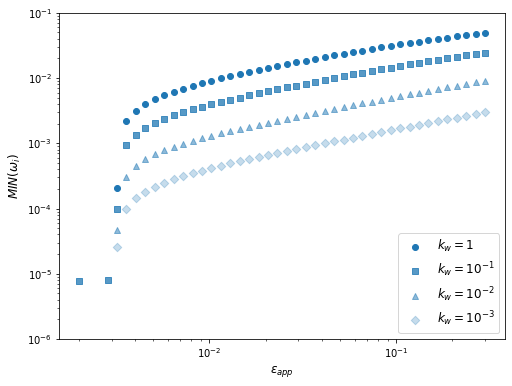

In [247]:
WT_d = 0.0875
d_intermediate = 0.123
Ecad_d = 0.158
d_large = 0.316

fig, ax = plt.subplots(figsize = (8, 6))

ax.scatter(eps_ps_test, np.sqrt(np.load('network_data/lowest_eigs_N25_WT_ind0.npy')), 
           label = '$k_w = 1$', color = 'tab:blue')
ax.scatter(eps_ps_test, np.sqrt(np.load('K_test_data/lowest_eigs_N25_WT_ind0_kind0.npy')), 
           label = '$k_w = 10^{-1}$', color = 'tab:blue', alpha = 0.75, marker = 's')
ax.scatter(eps_ps_test, np.sqrt(np.load('K_test_data/lowest_eigs_N25_WT_ind0_kind1.npy')), 
           label = '$k_w = 10^{-2}$', color = 'tab:blue', alpha = 0.5, marker = '^')
ax.scatter(eps_ps_test, np.sqrt(np.load('K_test_data/lowest_eigs_N25_WT_ind0_kind2.npy')), 
           label = '$k_w = 10^{-3}$', color = 'tab:blue', alpha = 0.25, marker = 'D')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('$\epsilon_{app}$', fontsize = 12)
ax.set_ylabel('$MIN(\omega_i)$', fontsize = 12)
ax.legend(fontsize = 12)

ax.set_ylim(1e-6, 1e-1)
plt.savefig('varying_k_omega_v2.pdf')

### Full prestress

In [11]:
def full_prestress(F, eps_p):
    
    prestrained_L0s = F.edgeLengths() / (1 + eps_p)
    
    # create prestrained network and energy minimize
    F_prestrained = rp.framework(F.coordinates, F.bonds, F.basis, k=np.diag(F.K), restLengths = prestrained_L0s)
    F_prestrained_minimized = energy_minimize(F_prestrained)
    
    return F_prestrained_minimized

In [31]:
'''
F0 = create_network(25)

WT_d = 0.0875
d_intermediate = 0.123
Ecad_d = 0.158
d_large = 0.316

prestrains = np.geomspace(1e-3, 1e-1)
sample_num = 10

lowest_eigs_WT = np.zeros((sample_num, len(prestrains)))
lowest_eigs_int = np.zeros((sample_num, len(prestrains)))
lowest_eigs_Ecad = np.zeros((sample_num, len(prestrains)))
lowest_eigs_large = np.zeros((sample_num, len(prestrains)))

for i in range(sample_num):
    FWT = add_disorder(F0, WT_d)
    Fint = add_disorder(F0, d_intermediate)
    FEcad = add_disorder(F0, Ecad_d)
    Flarge = add_disorder(F0, d_large)
    for j in range(len(prestrains)):
        Fp_WT = full_prestress(FWT, prestrains[j])
        Fp_int = full_prestress(Fint, prestrains[j])
        Fp_Ecad = full_prestress(FEcad, prestrains[j])
        Fp_large = full_prestress(Flarge, prestrains[j])
        
        lowest_eigs_WT[i][j] = lowest_eig(Fp_WT)
        lowest_eigs_int[i][j] = lowest_eig(Fp_int)
        lowest_eigs_Ecad[i][j] = lowest_eig(Fp_Ecad)
        lowest_eigs_large[i][j] = lowest_eig(Fp_large)
        
        save(Fp_WT, 'full_prestress_all_ds/net_WT_ind' + str(i) + '_pind' + str(j))
        save(Fp_int, 'full_prestress_all_ds/net_int_ind' + str(i) + '_pind' + str(j))
        save(Fp_Ecad, 'full_prestress_all_ds/net_Ecad_ind' + str(i) + '_pind' + str(j))
        save(Fp_large, 'full_prestress_all_ds/net_large_ind' + str(i) + '_pind' + str(j))
        
np.save('full_prestress_all_ds/lowest_eigs_WT', lowest_eigs_WT)
np.save('full_prestress_all_ds/lowest_eigs_int', lowest_eigs_int)
np.save('full_prestress_all_ds/lowest_eigs_Ecad', lowest_eigs_Ecad)
np.save('full_prestress_all_ds/lowest_eigs_large', lowest_eigs_large)
'''

"\nF0 = create_network(25)\n\nWT_d = 0.0875\nd_intermediate = 0.123\nEcad_d = 0.158\nd_large = 0.316\n\nprestrains = np.geomspace(1e-3, 1e-1)\nsample_num = 10\n\nlowest_eigs_WT = np.zeros((sample_num, len(prestrains)))\nlowest_eigs_int = np.zeros((sample_num, len(prestrains)))\nlowest_eigs_Ecad = np.zeros((sample_num, len(prestrains)))\nlowest_eigs_large = np.zeros((sample_num, len(prestrains)))\n\nfor i in range(sample_num):\n    FWT = add_disorder(F0, WT_d)\n    Fint = add_disorder(F0, d_intermediate)\n    FEcad = add_disorder(F0, Ecad_d)\n    Flarge = add_disorder(F0, d_large)\n    for j in range(len(prestrains)):\n        Fp_WT = full_prestress(FWT, prestrains[j])\n        Fp_int = full_prestress(Fint, prestrains[j])\n        Fp_Ecad = full_prestress(FEcad, prestrains[j])\n        Fp_large = full_prestress(Flarge, prestrains[j])\n        \n        lowest_eigs_WT[i][j] = lowest_eig(Fp_WT)\n        lowest_eigs_int[i][j] = lowest_eig(Fp_int)\n        lowest_eigs_Ecad[i][j] = lowest_ei

In [40]:
F0 = create_network(25)

ds = np.zeros((sample_num, len(prestrains), len(F0.coordinates)))

for i in range(sample_num):
    for j in range(len(prestrains)):
        F = load('full_prestress_all_ds/net_WT_ind' + str(i) + '_pind' + str(j))
        dx = F.coordinates.T[0] - F0.coordinates.T[0]
        dy = F.coordinates.T[1] - F0.coordinates.T[1]
        d = np.sqrt(dx**2 + dy**2)
        ds[i][j] = d

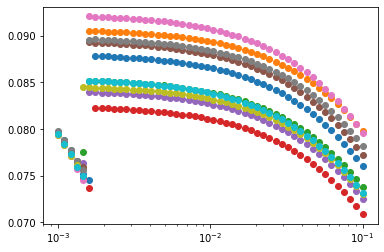

In [82]:
for i in range(sample_num):
    plt.scatter(prestrains, np.mean(ds[i], axis = 1))
plt.xscale('log')

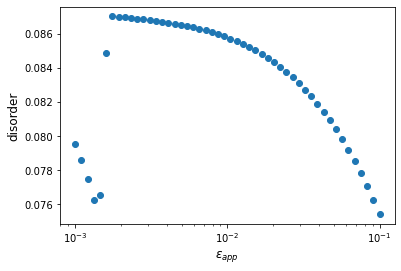

In [84]:
plt.scatter(prestrains, np.mean(ds, axis = (0, 2)))
plt.xscale('log')
#plt.yscale('log')

plt.xlabel('$\epsilon_{app}$', fontsize = 12)
plt.ylabel('disorder', fontsize = 12)

#plt.savefig('disorder_vs_epsapp.pdf')

<ipython-input-87-5495e8a6e8a6>:6: RuntimeWarning: invalid value encountered in sqrt
  plt.errorbar(prestrains, np.mean(np.sqrt(lowest_eigs_WT_load), axis = 0), \
<ipython-input-87-5495e8a6e8a6>:7: RuntimeWarning: invalid value encountered in sqrt
  np.std(np.sqrt(lowest_eigs_WT_load), axis = 0), linestyle = 'none', capsize = 4, label = 'd = ' + str(WT_d) + '(WT)', marker = '.')


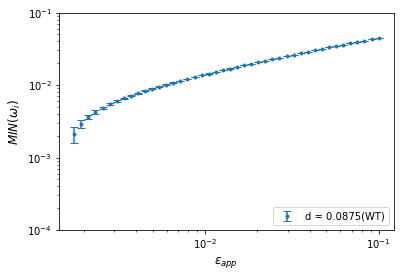

In [87]:
lowest_eigs_WT_load = np.load('full_prestress_all_ds/lowest_eigs_WT.npy')
lowest_eigs_int_load = np.load('full_prestress_all_ds/lowest_eigs_int.npy')
lowest_eigs_Ecad_load = np.load('full_prestress_all_ds/lowest_eigs_Ecad.npy')
lowest_eigs_large_load = np.load('full_prestress_all_ds/lowest_eigs_large.npy')

plt.errorbar(prestrains, np.mean(np.sqrt(lowest_eigs_WT_load), axis = 0), \
             np.std(np.sqrt(lowest_eigs_WT_load), axis = 0), linestyle = 'none', capsize = 4, label = 'd = ' + str(WT_d) + '(WT)', marker = '.')
#plt.errorbar(prestrains, np.mean(np.sqrt(lowest_eigs_int_load), axis = 0), \
             #np.std(np.sqrt(lowest_eigs_int_load), axis = 0), linestyle = 'none', capsize = 4, label = 'd = ' + str(d_intermediate), marker = '.')
#plt.errorbar(prestrains, np.mean(np.sqrt(lowest_eigs_Ecad_load), axis = 0), \
             #np.std(np.sqrt(lowest_eigs_Ecad_load), axis = 0), linestyle = 'none', capsize = 4, label = 'd = ' + str(Ecad_d), marker = '.')
#plt.errorbar(prestrains, np.mean(np.sqrt(lowest_eigs_large_load), axis = 0), \
             #np.std(np.sqrt(lowest_eigs_large_load), axis = 0), linestyle = 'none', capsize = 4, label = 'd = ' + str(d_large), marker = '.')


plt.xscale('log')
plt.yscale('log')

plt.ylim(1e-4, 1e-1)

plt.xlabel('$\epsilon_{app}$', fontsize = 12)
plt.ylabel('$MIN(\omega_i)$', fontsize = 12)
plt.legend(loc = 4)

#plt.savefig('min_omega_vs_epsapp_WTonly.pdf')

In [20]:
def varied_prestress(F, beta_eps_p):
    eps_ps = np.random.exponential(beta_eps_p, len(F.bonds))
    prestrained_L0s = F.edgeLengths() / (1 + eps_ps)
    
    # create prestrained network and energy minimize
    F_prestrained = rp.framework(F.coordinates, F.bonds, F.basis, k=np.diag(F.K), restLengths = prestrained_L0s)
    F_prestrained_minimized = energy_minimize(F_prestrained)
    
    return F_prestrained_minimized

In [72]:
def varied_k(F, beta_k):
    ks = 1 + np.random.exponential(beta_k, len(F.bonds))
    F_new = rp.framework(F.coordinates, F.bonds, F.basis, k=ks, restLengths = F.L0)
    F_minimized = energy_minimize(F_new)
    return F_minimized

In [78]:
energy(F10_init_pre)

1.4085077881567785

In [80]:
F10_p = varied_prestress(F10, beta_eps_ps[0])
energy(F10_p)

1.5090671792352528

array([1.37770969, 1.1287284 , 0.88012074, 0.71481663, 0.59769958,
       0.51113815, 0.37830246, 0.3156326 , 0.25797436, 0.20547759,
       0.16128877, 0.13555831, 0.10015427, 0.08316729, 0.07292325])

In [86]:
F10 = create_network(10)
N = len(F10.coordinates)
beta_eps_ps = np.geomspace(1e-1, 2e-1, 15)
sample_num = 10
ds = np.zeros((sample_num, len(beta_eps_ps), N))
Energies = np.zeros((sample_num, len(beta_eps_ps)))
for i in range(sample_num):
    for j in range(len(beta_eps_ps)):
        F10_p = varied_prestress(F10, beta_eps_ps[j])
        d = np.sqrt(np.sum((F10_p.coordinates - F10.coordinates)**2, axis = 1))
        ds[i][j] = d
        Energies[i][j] = energy(F10_p)
dmean = np.mean(ds, axis=(0, 2))
dstd = np.std(ds, axis=(0, 2))
Emean = np.mean(Energies, axis = 0)
Estd = np.std(Energies, axis = 0)

beta_ks = np.geomspace(1e-1, 2, 15)
ds_k = np.zeros((sample_num, len(beta_ks), N))
Energies_k = np.zeros((sample_num, len(beta_ks)))
F10_init_pre = full_prestress(F10, 1e-1)

for i in range(sample_num):
    for j in range(len(beta_ks)):
        F10_p = varied_k(F10_init_pre, beta_ks[j])
        d = np.sqrt(np.sum((F10_p.coordinates - F10_init_pre.coordinates)**2, axis = 1))
        ds_k[i][j] = d
        Energies_k[i][j] = energy(F10_p)
        
dmean_k = np.mean(ds_k, axis=(0, 2))
dstd_k = np.std(ds_k, axis=(0, 2))
Emean_k = np.mean(Energies_k, axis = 0)
Estd_k = np.std(Energies_k, axis = 0)

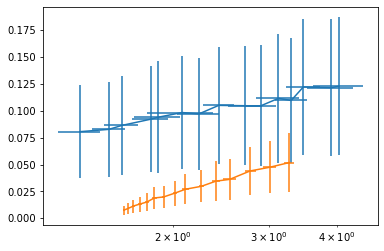

In [87]:
plt.errorbar(Emean, dmean, yerr=dstd, xerr=Estd)
plt.errorbar(Emean_k, dmean_k, yerr=dstd_k, xerr=Estd_k)
plt.xscale('log')

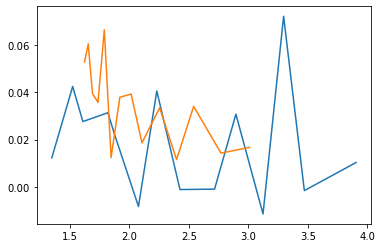

In [95]:
plt.plot(Emean[0:-1], np.diff(dmean) / np.diff(Emean))
plt.plot(Emean_k[0:-1], np.diff(dmean_k) / np.diff(Emean_k))

In [89]:
#'''
F22 = create_network(10)
eps_ps_test = np.geomspace(1e-3, 3e-1)
start_p = 30
init_spread = 0.1
sample_num = 10

for i in range(sample_num):
    
    k1 = np.random.normal(1, init_spread, len(F22.bonds))
    k25 = np.random.normal(2.5, 2.5 * init_spread, len(F22.bonds))
    k5 = np.random.normal(5, 5 * init_spread, len(F22.bonds))
    k75 = np.random.normal(7.5, 7.5 * init_spread, len(F22.bonds))
    k10 = np.random.normal(10, 10 * init_spread, len(F22.bonds))

    F22_k1 = rp.framework(F22.coordinates, F22.bonds, F22.basis, k=k1)
    
    for j in range(start_p, len(eps_ps_test)):
        Fp = full_prestress(F22_k1, eps_ps_test[j])
        save(Fp, 'norm_k_with_added_prestress/sample_num' + str(i) + '_pind' + str(j))
        
    F22_k1p = full_prestress(F22_k1, eps_ps_test[start_p])
    F22_k25p = energy_minimize(rp.framework(F22_k1p.coordinates, F22_k1p.bonds, F22_k1p.basis, k=k25, restLengths=F22_k1p.L0))
    F22_k5p = energy_minimize(rp.framework(F22_k1p.coordinates, F22_k1p.bonds, F22_k1p.basis, k=k5, restLengths=F22_k1p.L0))    
    F22_k75p = energy_minimize(rp.framework(F22_k1p.coordinates, F22_k1p.bonds, F22_k1p.basis, k=k75, restLengths=F22_k1p.L0))
    F22_k10p = energy_minimize(rp.framework(F22_k1p.coordinates, F22_k1p.bonds, F22_k1p.basis, k=k10, restLengths=F22_k1p.L0))    

    
    #F22_k25 = rp.framework(F22.coordinates, F22.bonds, F22.basis, k=k25)
    #F22_k5 = rp.framework(F22.coordinates, F22.bonds, F22.basis, k=k5)
    #F22_k75 = rp.framework(F22.coordinates, F22.bonds, F22.basis, k=k75)
    #F22_k10 = rp.framework(F22.coordinates, F22.bonds, F22.basis, k=k10)
    
    #F22_k25p = full_prestress(F22_k25, eps_ps_test[start_p])
    #F22_k5p = full_prestress(F22_k5, eps_ps_test[start_p])
    #F22_k75p = full_prestress(F22_k75, eps_ps_test[start_p])
    #F22_k10p = full_prestress(F22_k10, eps_ps_test[start_p])
    
    save(F22_k25p, 'norm_k_no_added_prestress/sample_num' + str(i) + '_k25')
    save(F22_k5p, 'norm_k_no_added_prestress/sample_num' + str(i) + '_k5')
    save(F22_k75p, 'norm_k_no_added_prestress/sample_num' + str(i) + '_k75')
    save(F22_k10p, 'norm_k_no_added_prestress/sample_num' + str(i) + '_k10')
#'''

FileExistsError: [Errno 17] File exists: 'norm_k_with_added_prestress/sample_num0_pind30'

In [91]:
ds = np.zeros((sample_num, len(eps_ps_test) - start_p, len(F22.bonds)))
Es = np.zeros((sample_num, len(eps_ps_test) - start_p))

ds_k = np.zeros((sample_num, 4, len(F22.bonds))) 
Es_k = np.zeros((sample_num, 4))

for i in range(sample_num):
    count = 0
    for j in range(start_p, len(eps_ps_test)):
        F = load('norm_k_with_added_prestress/sample_num' + str(i) + '_pind' + str(j))
        d = np.sqrt(np.sum((F.coordinates - F22.coordinates)**2, axis = 1))
        ds[i][count] = d
        Es[i][count] = energy(F)
        count = count + 1
        
    F22_k25p = load('norm_k_no_added_prestress/sample_num' + str(i) + '_k25')
    F22_k5p = load('norm_k_no_added_prestress/sample_num' + str(i) + '_k5')
    F22_k75p = load('norm_k_no_added_prestress/sample_num' + str(i) + '_k75')
    F22_k10p = load('norm_k_no_added_prestress/sample_num' + str(i) + '_k10')
    
    d25 = np.sqrt(np.sum((F22_k25p.coordinates - F22.coordinates)**2, axis = 1))
    d5 = np.sqrt(np.sum((F22_k5p.coordinates - F22.coordinates)**2, axis = 1))
    d75 = np.sqrt(np.sum((F22_k75p.coordinates - F22.coordinates)**2, axis = 1))
    d10 = np.sqrt(np.sum((F22_k10p.coordinates - F22.coordinates)**2, axis = 1))
    
    Es_k[i][0] = energy(F22_k25p)
    Es_k[i][1] = energy(F22_k5p)
    Es_k[i][2] = energy(F22_k75p)
    Es_k[i][3] = energy(F22_k10p)
    
    ds_k[i][0] = d25
    ds_k[i][1] = d5
    ds_k[i][2] = d75
    ds_k[i][3] = d10


ValueError: could not broadcast input array from shape (240,) into shape (360,)

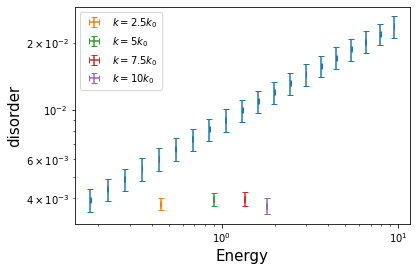

In [100]:
plt.errorbar(np.mean(Es, axis=0), np.mean(ds, axis=(0, 2)), yerr=np.std(ds, axis=(0, 2)), xerr=np.std(Es, axis=0), \
             linestyle = 'none', capsize = 3)

ks_mult = ['2.5', '5', '7.5', '10']
for i in range(4):
    plt.errorbar(np.mean(Es_k, axis=0)[i], np.mean(ds_k, axis=axis=(0, 2))[i], yerr=np.std(ds_k, axis=axis=(0, 2))[i], xerr=np.std(Es_k, axis=0)[i], \
             linestyle = 'none', capsize = 3, label = '$k = $' +ks_mult[i] + '$k_0$')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Energy', fontsize = 15)
plt.ylabel('disorder', fontsize = 15)
plt.legend()

In [82]:
k1 = np.random.normal(1, init_spread, len(F22.bonds))
k25 = np.random.normal(2.5, init_spread, len(F22.bonds))
k5 = np.random.normal(5, init_spread, len(F22.bonds))
k75 = np.random.normal(7.5, init_spread, len(F22.bonds))
k10 = np.random.normal(10, init_spread, len(F22.bonds))

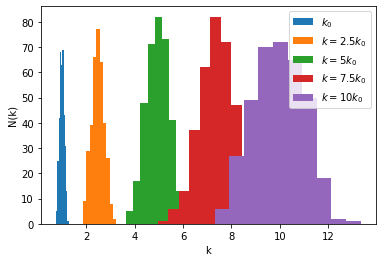

In [103]:
plt.hist(k1, label = '$k_0$')
plt.hist(k25, label = '$k = $' +ks_mult[0] + '$k_0$')
plt.hist(k5, label = '$k = $' +ks_mult[1] + '$k_0$')
plt.hist(k75, label = '$k = $' +ks_mult[2] + '$k_0$')
plt.hist(k10, label = '$k = $' +ks_mult[3] + '$k_0$')

plt.xlabel('k')
plt.ylabel('N(k)')
plt.legend()

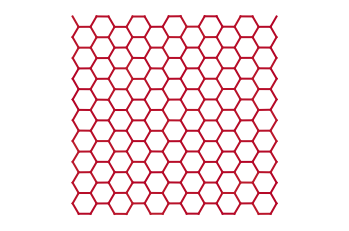

In [73]:
plot(F22_k10p)

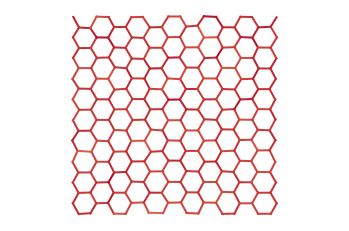

In [74]:
plot(F)